参考：https://blog.csdn.net/a19990412/article/details/85139058


# 导库与设置

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

import numpy as np
import pandas as pd

import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import pickle

# 定义损失函数
!pip install torchmetrics
from torchmetrics import MeanAbsolutePercentageError

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# working directory
root_path = os.path.abspath(os.path.dirname('/content/drive/MyDrive/Colab Notebooks/Multivariate-time-series-forecasting-using-LSTM/'))
os.chdir(root_path)
# data path
train_data = os.path.join(root_path, 'train.csv')
test_data = os.path.join(root_path, 'test.csv')

model_save_name = os.path.join(root_path, 'model.pt')
losses_path = os.path.join(root_path, 'validation_loss.pkl')

# cuda
is_cuda = True
DEVICE = torch.device('cuda') if is_cuda else torch.device('cpu')

#
torch.set_default_tensor_type(torch.FloatTensor)

# dataset process
train_dev_split_rate = 0.4
dev_test_split_rate = 0.3
# train
window = 10
batch_size = 1
input_size = 5 # 多变量变量的个数，或者单个词汇的词向量维度
hidden_layer_size = 1024
num_layers = 1
output_size = 1
epochs = 15
lr = 0.0001
lstm_dropout = 0.5

# auto save
model_name = 'Model' + '_' + str(window)

directory_path = os.path.join(root_path, 'model_save/' + model_name + '/')
if not os.path.exists(directory_path):
  os.makedirs(directory_path)


model_save_path = os.path.join(root_path, 'model_save/' + model_name + '/model.pt')
losses_path = os.path.join(root_path, 'model_save/' + model_name + '/validation_loss.pkl')

# 数据探索与处理

In [ ]:
class Scaler():
  """
  使用 refer_dataset 的最大值和最小值来标准化其他数据集
  """
  def __init__(self, refer_dataset):
    self.data_max = np.max(refer_dataset)
    self.data_min = np.min(refer_dataset)

  def scaler(self, dataset):
    data_scaled = (dataset-self.data_min)/(self.data_max-self.data_min)

    return data_scaled
  
  def inv_scaler (self, scaled_dataset, dimension = 0 ):
    data_unscaled = scaled_dataset * (self.data_max[dimension] - self.data_min[dimension]) + self.data_min[dimension]

    return data_unscaled

In [ ]:
def createXY_with_window(dataset, window):
    """
    Use the data of the first n days as features and the open of the n+1th day as label for prediction
    """
    dataX = []
    dataY = []
    for i in range(window, len(dataset)):
            dataX.append(dataset.iloc[i - window:i, 0:dataset.shape[1]])
            dataY.append([dataset.iloc[i,0]])
    return np.array(dataX), np.array(dataY)        

In [ ]:
def data_set_split(dataset, split_rate):
  """
  依次划分并返回 (1-split_rate) * dataset 和 split_rate * dataset 的数据集
  """
  rate = round(len(dataset)*split_rate)
  df_maj = dataset[:-rate]
  df_min = dataset[-rate:]

  return df_maj, df_min

In [ ]:
def SampleDataset(X, Y):
  X = torch.tensor(X, dtype = float).to(DEVICE)
  Y = torch.tensor(Y, dtype = float).to(DEVICE)
  torch_dataset = Data.TensorDataset(X, Y)
  loader = Data.DataLoader(
      dataset = torch_dataset
      ,batch_size = batch_size
      ,shuffle = False
      #,pin_memory = True
      )
  return loader

In [ ]:
# class PairDataset:
#   def __init__(self, dataset, split_rate = train_dev_split_rate, device = DEVICE):
#     self.dataset = dataset
#     self.DEVICE = device
#     self.window = window
#     self.split_rate = split_rate


#   # def createXY_with_window(self, dataset, window = window):
#   #   """
#   #   Use the data of the first n days as features and the open of the n+1th day as label for prediction
#   #   """
#   #   dataX = []
#   #   dataY = []
#   #   for i in range(self.window, len(dataset)):
#   #           dataX.append(dataset.iloc[i - self.window:i, 0:dataset.shape[1]])
#   #           dataY.append([dataset.iloc[i,0]])
#   #   return np.array(dataX), np.array(dataY)

#   # def data_set_split(dataset, split_rate):
#   #   """
#   #   依次划分并返回 (1-split_rate) * dataset 和 split_rate * dataset 的数据集
#   #   """
#   #   rate = round(len(dataset)*split_rate)
#   #   df_maj = dataset[:-rate]
#   #   df_min = dataset[-rate:]
    
#   #   print(df_maj.shape, df_min.shape)

#   #   return df_maj, df_min 

#   # def SampleDataset(self, X, Y):
#   #   X = torch.tensor(X, dtype = float).to(self.DEVICE)
#   #   Y = torch.tensor(Y, dtype = float).to(self.DEVICE)
#   #   torch_dataset = Data.TensorDataset(X, Y)
#   #   loader = Data.DataLoader(
#   #       dataset = torch_dataset
#   #       ,batch_size = batch_size
#   #       ,shuffle = False
#   #       #,pin_memory = True
#   #       )
#   #   return loader

#   def __getitem__(self, key):
#     self.X, self.Y = createXY_with_window(self.dataset, self.window)

#     self.trainX, self.devX = data_set_split(self.X, self.split_rate)
#     self.trainY, self.devY = data_set_split(self.Y, self.split_rate)

#     loader_train = SampleDataset(self.trainX, self.trainY)
#     loader_test = SampleDataset(self.devX, self.devY)

#     return loader_train, loader_test

In [ ]:
# trainX, devX = data_set_split(X, train_dev_split_rate)
# devX, testX = data_set_split(devX, dev_test_split_rate)

# trainY, devY = data_set_split(Y, train_dev_split_rate)
# devY, testY = data_set_split(devY, dev_test_split_rate)

In [ ]:
# X = torch.tensor(X, dtype = float).to(DEVICE)
# Y = torch.tensor(Y, dtype = float).to(DEVICE)
# trainX = torch.tensor(trainX, dtype = float).to(DEVICE)
# trainY = torch.tensor(trainY, dtype = float).to(DEVICE)
# devX = torch.tensor(devX, dtype = float).to(DEVICE)
# devY = torch.tensor(devY, dtype = float).to(DEVICE)
# testX = torch.tensor(testX, dtype = float).to(DEVICE)
# testY = torch.tensor(testY, dtype = float).to(DEVICE)

In [ ]:
# torch_dataset = Data.TensorDataset(X, Y)
# torch_dataset_train = Data.TensorDataset(trainX, trainY)
# torch_dataset_dev = Data.TensorDataset(devX, devY)
# torch_dataset_test = Data.TensorDataset(testX, testY)

In [ ]:
# loader = Data.DataLoader(
#     dataset = torch_dataset
#     ,batch_size = batch_size
#     ,shuffle = False
#     #,pin_memory = True
# )
# loader_train = Data.DataLoader(
#     dataset = torch_dataset_train
#     ,batch_size = batch_size
#     ,shuffle = False
#     #,pin_memory = True
# )
# loader_dev = Data.DataLoader(
#     dataset = torch_dataset_train
#     ,batch_size = batch_size
#     ,shuffle = False
#     #,pin_memory = True
# )
# loader_test = Data.DataLoader(
#     dataset = torch_dataset_test
#     ,batch_size = batch_size
#     ,shuffle = False
#     #,pin_memory = True
# )

# 模型构建

In [ ]:
# # 神经网络模块调试        
# #input = torch.randn(30, 1, 5) #(L, N, Hin)
# # 输入的input为，序列长度seq_len=30, 每次取的minibatch大小，batch_size=1, 数据向量维数=5（仍然为x的维度）。每次运行时取1个含有30个日期序列的时间序列数据（且每个时间节点的每个数据的维度为5进行运行）
# input = torch.randn(batch_size, window, input_size) #如果batch_first = True，input的输入需要改变顺序为 (N, L, Hin)

# lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True) 
# # 输入数据x的向量维数10, 设定lstm隐藏层的特征维度20, 此model用2个lstm层。如果是1，可以省略，默认为1) 
# # 初始化的隐藏元和记忆元,通常它们的维度是一样的
# # 2个LSTM层，batch_size=1, 隐藏层的特征维度20
# h_0 = torch.randn(num_layers, batch_size, hidden_layer_size)
# c_0 = torch.randn(num_layers, batch_size, hidden_layer_size)
 
# # 这里有2层lstm，output是最后一层lstm的每个词向量对应隐藏层的输出,其与层数无关，只与序列长度相关
# # hn,cn是所有层最后一个隐藏元和记忆元的输出
# output_lstm, (h_n, c_n) = lstm(input, (h_0, c_0))

# linear = nn.Linear(hidden_layer_size, output_size)
# output = linear(output_lstm[-1,-1])
# # output2 = output[-1,0] # 最后一个时间节点的开盘日的数据（第一列数据)
# ##模型的三个输入与三个输出。三个输入与输出的理解见上三输入，三输出
 
# print(output.size())

In [ ]:
class Model(nn.Module):
  def __init__(self, input_size=input_size, hidden_layer_size=hidden_layer_size, num_layers=num_layers, output_size=output_size):
    super(Model, self).__init__()
    self.hidden_layer_size = hidden_layer_size
    self.num_layers = num_layers
    self.num_directions = 1 # 单向LSTM
    self.lstm_dropout = lstm_dropout
    self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, dropout = lstm_dropout, bias = True) # batch_first TRUE -> (batch_size, seq_len, features)
    self.linear = nn.Linear(hidden_layer_size, output_size)

  # def load_model(self):
  #   """Load saved model if there exits one.
  #   """        
  #   if (os.path.exists(model_save_name)):
  #       self.lstm = torch.load(model_save_name)

  def forward(self, input_seq):
      #h0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size, device=input_seq.device).requires_grad_().flatten(start_dim=1) #h0 c0是模型训练中产生的数据，需要手动放到GPU上
      #c0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size, device=input_seq.device).requires_grad_().flatten(start_dim=1)
      
      #h0 c0是模型训练中产生的数据，需要手动放到GPU上
      h0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size, device=input_seq.device).requires_grad_() #h_0(num_directions * num_layers, batch_size, hidden_size) num_directions：如果是双向LSTM，则num_directions=2；否则num_directions=1。
      c0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size, device=input_seq.device).requires_grad_() #c_0(num_directions * num_layers, batch_size, hidden_size)
      out_lstm, (hn, cn) = self.lstm(input_seq, (h0.detach(), c0.detach())) # batch_first TRUE -> output(batch_size, seq_len, num_directions * hidden_size)
      #out = self.linear(out_lstm).squeeze()[-1,0] # 都一个时间点的input都会有一个对应的输出，因此如果只需要最后一个时间节点的输出，需要先压缩成一维，然后取最后一个数
      out = self.linear(out_lstm[-1,-1]) # 输出数据结构为 (batch_size, seq_len, hidden_layer_size)，torch.Size([1, 30, 128])，因此需要只取最后一个时间节点作为预测值
      
      return out.float()



In [ ]:
def train(training_set, dev_set):
  model = Model()

  if (os.path.exists(model_save_path)):
    model = torch.load(model_save_path)
  model.to(DEVICE)
  print(next(model.parameters()).device)

  # 定义为 MAPE： 平均绝对百分比误差（Mean Absolute Percentage Error）
  loss_function = MeanAbsolutePercentageError().to(DEVICE)
  # loss_function = nn.MSELoss()

  # 定义优化器
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  val_losses = np.inf
  if (os.path.exists(losses_path)):
      with open(losses_path, 'rb') as f:
          val_losses = pickle.load(f)

  train_loss = []
  dev_loss = []

  for i in tqdm(range(epochs)):
      for seq, labels in training_set:
        optimizer.zero_grad()
        y_pred = model(seq.float()) # unsqueeze在这里将[30，5]转变为[1, 30, 5]以此来符合input的要求 当batch_first=True时 input=(N, L, Hin(input_size))
        single_loss = loss_function(y_pred.float(), labels.squeeze(0).float())
        single_loss.backward()
        optimizer.step()

      # validation loss
      for seq, labels in dev_set:
        val_y_pred = model(seq.float())
        val_loss = loss_function(val_y_pred, labels.squeeze(0))

      print(f'epoch: {i:3} train_loss: {single_loss.item():10.8f}', f'dev_loss: {val_loss.item():10.8f}' )

      train_loss.append(single_loss.item())
      dev_loss.append(val_loss.item())

      # Update minimum evaluating loss.
      if (val_loss < val_losses):
          torch.save(model, model_save_path)
          print('Better parameters found and saved !')
          val_losses = val_loss
      with open(losses_path, 'wb') as f:
          pickle.dump(val_losses, f)

  plt.plot(train_loss, color = 'red', label = 'train_loss')
  plt.plot(dev_loss, color = 'blue', label = 'validation_loss')
  plt.legend()
  plt.show()

In [ ]:
def predict(loader):
  prediction_scaled = []
  prediction = []
  labels_scaled = []
  labels = []

  for seq, label in loader:
    y_pred = model(seq.float()).cpu().detach().numpy()
    prediction_scaled.append(y_pred)
    labels_scaled.append(label[-1].cpu().detach().numpy())
  
  for item in prediction_scaled:
    prediction.append(scaler.inv_scaler(item[0]))

  for item in labels_scaled:
    labels.append(scaler.inv_scaler(item[0]))

  return prediction, labels

# 执行

准备数据集

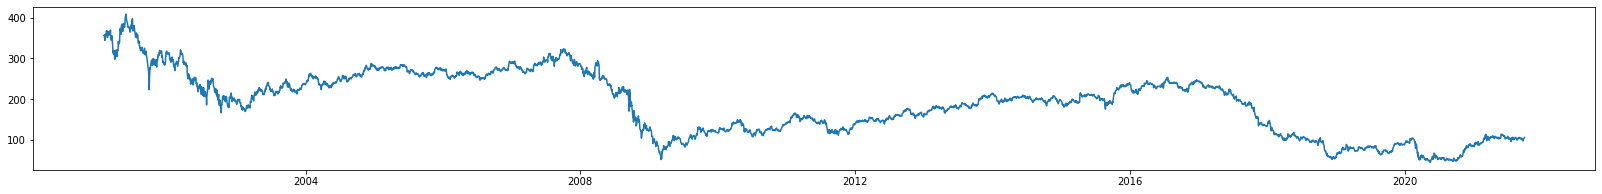

3116 1454 623


In [ ]:
dataset = pd.read_csv(train_data,parse_dates = ["Date"], index_col = [0])
plt.figure(figsize=(28,3))
plt.plot(dataset.iloc[:,0])
plt.show()

scaler = Scaler(dataset)
dataset_scaled = scaler.scaler(dataset)
X, Y = createXY_with_window(dataset_scaled, window) 
trainX, devX = data_set_split(X, train_dev_split_rate)
trainY, devY = data_set_split(Y, train_dev_split_rate)
devX, testX = data_set_split(devX, dev_test_split_rate)
devY, testY = data_set_split(devY, dev_test_split_rate)
print(len(trainX), len(devX), len(testX))
loader = SampleDataset(X, Y)
loader_train = SampleDataset(trainX, trainY)
loader_dev = SampleDataset(devX, devY)
loader_test = SampleDataset(testX, testY)

训练模型

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


cuda:0


  7%|▋         | 1/15 [00:10<02:26, 10.50s/it]

epoch:   0 train_loss: 0.01760964 dev_loss: 0.71219498


 13%|█▎        | 2/15 [00:20<02:16, 10.47s/it]

epoch:   1 train_loss: 0.00571931 dev_loss: 0.66390163
Better parameters found and saved !


 20%|██        | 3/15 [00:31<02:05, 10.45s/it]

epoch:   2 train_loss: 0.00828624 dev_loss: 0.62040508
Better parameters found and saved !


 27%|██▋       | 4/15 [00:41<01:54, 10.43s/it]

epoch:   3 train_loss: 0.01227248 dev_loss: 0.56936365
Better parameters found and saved !


 33%|███▎      | 5/15 [00:52<01:44, 10.45s/it]

epoch:   4 train_loss: 0.00057344 dev_loss: 0.56200314
Better parameters found and saved !


 40%|████      | 6/15 [01:02<01:33, 10.42s/it]

epoch:   5 train_loss: 0.00400905 dev_loss: 0.54463172
Better parameters found and saved !


 47%|████▋     | 7/15 [01:12<01:23, 10.39s/it]

epoch:   6 train_loss: 0.01635271 dev_loss: 0.57666826


 53%|█████▎    | 8/15 [01:23<01:12, 10.36s/it]

epoch:   7 train_loss: 0.01691097 dev_loss: 0.54825199


 60%|██████    | 9/15 [01:33<01:02, 10.39s/it]

epoch:   8 train_loss: 0.00697632 dev_loss: 0.51440328
Better parameters found and saved !


 67%|██████▋   | 10/15 [01:44<00:51, 10.37s/it]

epoch:   9 train_loss: 0.01679630 dev_loss: 0.51614201


 73%|███████▎  | 11/15 [01:54<00:41, 10.38s/it]

epoch:  10 train_loss: 0.01905030 dev_loss: 0.50986958
Better parameters found and saved !


 80%|████████  | 12/15 [02:04<00:31, 10.38s/it]

epoch:  11 train_loss: 0.00973453 dev_loss: 0.49187830
Better parameters found and saved !


 87%|████████▋ | 13/15 [02:15<00:20, 10.43s/it]

epoch:  12 train_loss: 0.01105062 dev_loss: 0.49758118


 93%|█████████▎| 14/15 [02:25<00:10, 10.42s/it]

epoch:  13 train_loss: 0.00770574 dev_loss: 0.47770768
Better parameters found and saved !


100%|██████████| 15/15 [02:36<00:00, 10.41s/it]

epoch:  14 train_loss: 0.01566947 dev_loss: 0.52979606


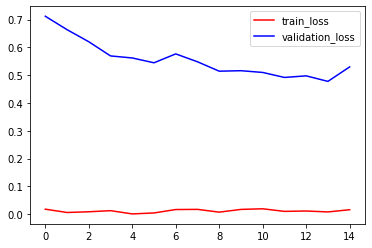

In [ ]:
train(loader_train, loader_dev)

可视化测试集结果

In [ ]:
model = torch.load(model_save_path)
prediction, labels = predict(loader)
prediction_training = prediction[:(len(prediction) - (len(loader_test) + len(loader_dev)))]
prediction_dev = prediction[:(len(prediction) - len(loader_test))]
prediction_test = prediction

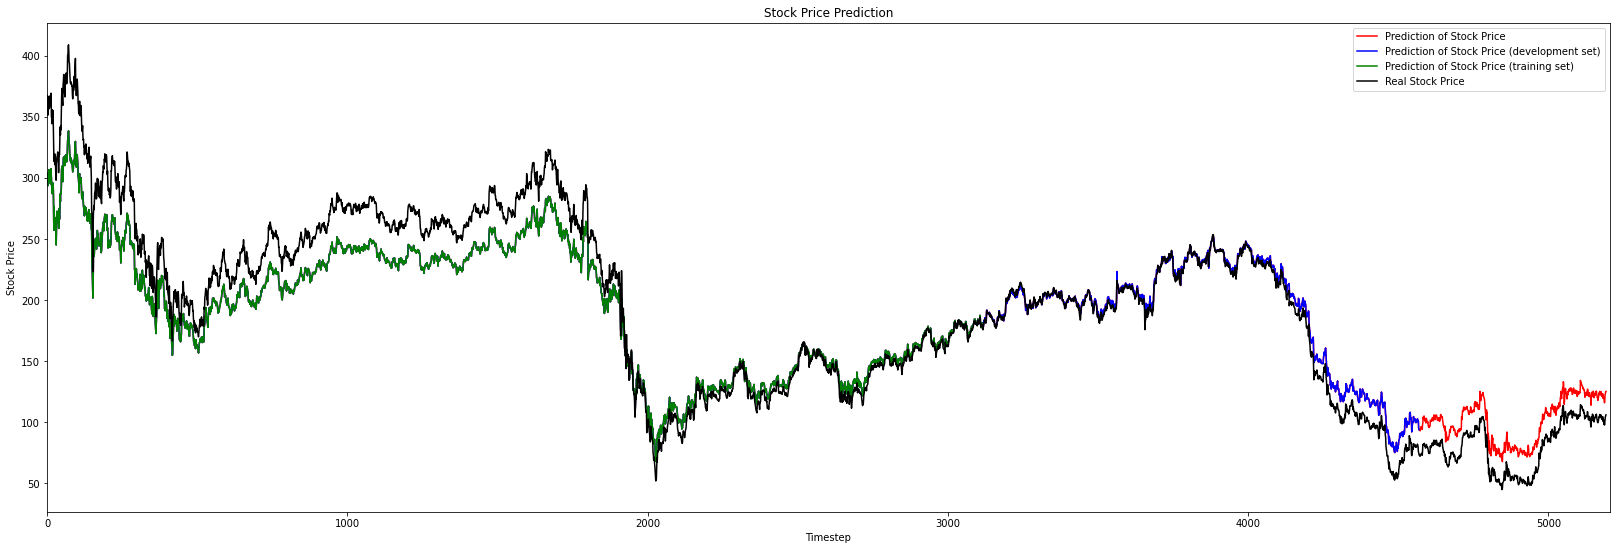

In [ ]:
# 可视化
plt.figure(figsize=(28,9))
plt.xlim((0, 5204)) # 设置坐标轴

plt.plot(prediction_test, color = 'red', label = 'Prediction of Stock Price')
plt.plot(prediction_dev, color = 'blue', label = 'Prediction of Stock Price (development set)')
plt.plot(prediction_training, color = 'green', label = 'Prediction of Stock Price (training set)')
plt.plot(labels, color = 'black', label = 'Real Stock Price')


plt.title('Stock Price Prediction')
plt.xlabel('Timestep')
plt.ylabel('Stock Price')
plt.legend()
plt.show()